In [143]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import DataLoader

data_dir = Path("../data/wqp")
basin_list_file = data_dir / "metadata" / "site_lists" / "sites_ssc_area10000_range10_qcorr0.1_redcorr0.1_n10.txt"

sequence_length = 30
batch_size = 256

with open(basin_list_file, 'r') as file:
    basin_list = file.readlines()
    basin_list = [basin.strip() for basin in basin_list]

data_params = {'data_dir': data_dir,
               'basins': basin_list,
               'features_dict': {'daily':['grfr_q'],
                                 'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']},
               'target': 'ssc',
               'time_slice': slice('1979-01-01', '2018-12-31'),
               'split_time': np.datetime64('2010-01-01'),
               'batch_size': batch_size,
               'sequence_length': sequence_length,
               'discharge_col': 'grfr_q'}

dataloader = DataLoader(**data_params)

In [153]:
importlib.reload(models)
importlib.reload(train)
from models import TAPLSTM, EALSTM, LSTM
from train import make_step

daily_in_size = len(data_params['features_dict']['daily'])
irregular_in_size = len(data_params['features_dict']['irregular'])
static_in_size = dataloader.x_s[basin_list[0]].shape[0]
out_size = 1
hidden_size = 128
dropout = 0.4
key = jax.random.PRNGKey(0)

num_epochs =  100
# lr_schedule = optax.polynomial_schedule(0.01, 0.0001, 2, num_epochs)
lr_schedule = optax.exponential_decay(0.01, num_epochs/2, 0.1)

model = TAPLSTM(daily_in_size, irregular_in_size, static_in_size, out_size, hidden_size, key=key, dropout=dropout)
# model = LSTM(daily_in_size, output_size, hidden_size, key=key, dropout=dropout)
# model = EALSTM(daily_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)

# Initialize optimizer 
current_lr = lr_schedule(0)
optim = optax.adam(current_lr)
opt_state = optim.init(model)

# Training loop
loss_list = []
# pbar = trange(num_epochs, desc="Epoch")
# for epoch in pbar:
for epoch in range(num_epochs):
    # jax.profiler.start_trace(f"/Users/Ted/Documents/GitHub/tss-ml/tmp/profile_{epoch}") 
    current_lr = lr_schedule(epoch)
    optim = optax.adam(current_lr)
    total_loss = 0
    num_batches = 0
    dataloader.train = True
    pbar = tqdm(dataloader, desc=f"Epoch:{epoch} LR:{current_lr:0.4f}")
    for basins, _, batch in pbar:
        """
        Try except block right now to try and diagnose the infrequent runtime error with jnp.where in TEALSTMCell.
        See Notion for notes on issue.
        """
        try:
            loss, model, opt_state = make_step(model, batch, opt_state, optim,
                                               loss_name="mse",
                                               max_grad_norm=3)
                                               # l2_weight = 1E-4)
            total_loss += loss
            num_batches += 1
            pbar.set_postfix_str(f"Loss: {total_loss/num_batches:.4f}")
        except Exception:
            print(f"Broken model run at epoch {epoch}")
            continue
            
    current_loss = total_loss / num_batches
    loss_list.append(current_loss)
    # pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

    # jax.profiler.stop_trace()

plt.plot(loss_list)
plt.ylabel("Loss")
plt.xlabel("Epoch")

Epoch:0 LR:0.0100:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:1 LR:0.0095:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:2 LR:0.0091:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:3 LR:0.0087:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:4 LR:0.0083:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:5 LR:0.0079:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:6 LR:0.0076:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:7 LR:0.0072:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:8 LR:0.0069:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:9 LR:0.0066:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:10 LR:0.0063:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:11 LR:0.0060:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:12 LR:0.0058:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:13 LR:0.0055:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:14 LR:0.0052:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:15 LR:0.0050:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:16 LR:0.0048:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:17 LR:0.0046:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:18 LR:0.0044:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:19 LR:0.0042:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:20 LR:0.0040:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:21 LR:0.0038:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:22 LR:0.0036:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:23 LR:0.0035:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:24 LR:0.0033:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:25 LR:0.0032:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:26 LR:0.0030:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:27 LR:0.0029:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:28 LR:0.0028:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:29 LR:0.0026:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:30 LR:0.0025:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:31 LR:0.0024:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:32 LR:0.0023:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:33 LR:0.0022:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:34 LR:0.0021:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:35 LR:0.0020:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:36 LR:0.0019:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:37 LR:0.0018:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch:38 LR:0.0017:   0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/296 [00:00<?, ?it/s]

/Users/Ted/Documents/GitHub/tss-ml/src/metrics.py:13: RuntimeWarning: Mean of empty slice
  return np.nanmean((y - y_hat)**2)
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/Ted/Library/Caches/pypoetry/v

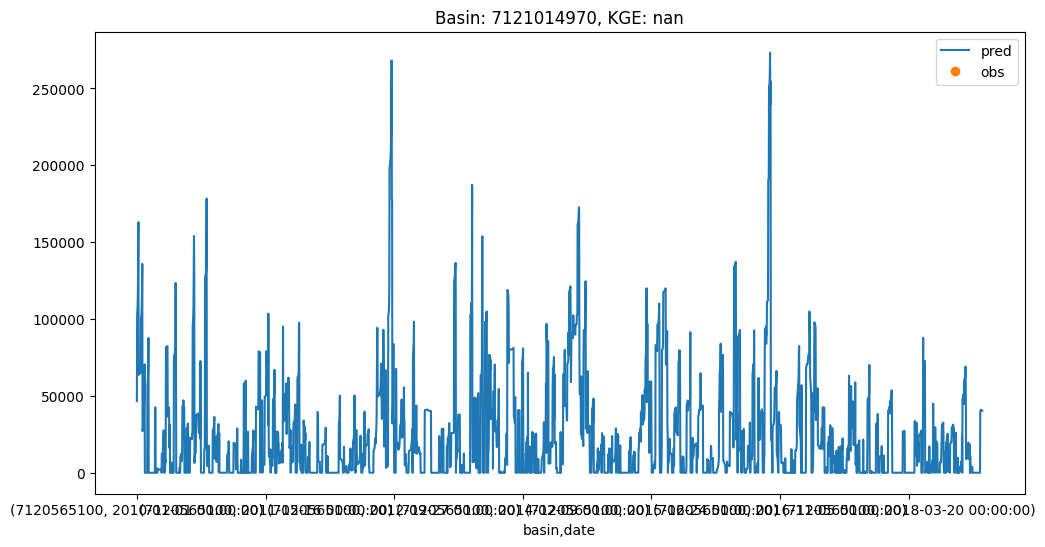

In [160]:
from metrics import get_all_metrics
from matplotlib.dates import YearLocator, DateFormatter
import datetime 

importlib.reload(evaluate)
from evaluate import predict

basin_subset = np.random.choice(basin_list).tolist()
results = predict(model, dataloader, basin_subset=basin_subset)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])

# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='o')

plt.title(f"Basin: {basin_id}, KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.show()

In [95]:
results

obs        pred
basin      date                       
7121116600 2010-01-01  NaN  426.182892
           2010-01-02  NaN  427.045074
           2010-01-03  NaN  428.252380
           2010-01-04  NaN  430.064178
           2010-01-05  NaN  433.085846
...                    ...         ...
           2018-12-27  NaN    9.037933
           2018-12-28  NaN   10.495056
           2018-12-29  NaN   12.929474
           2018-12-30  NaN   17.807617
           2018-12-31  NaN   32.569336

[3287 rows x 2 columns]

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

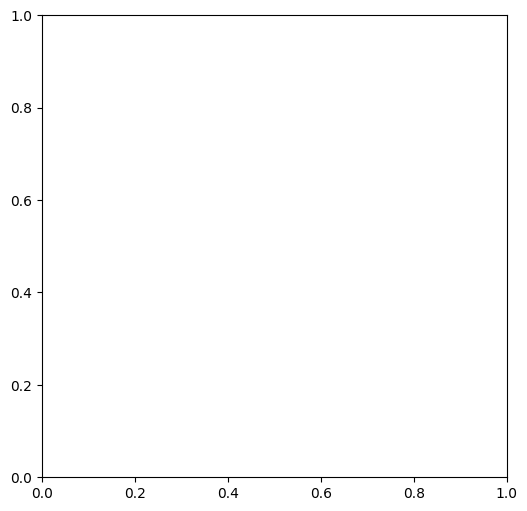

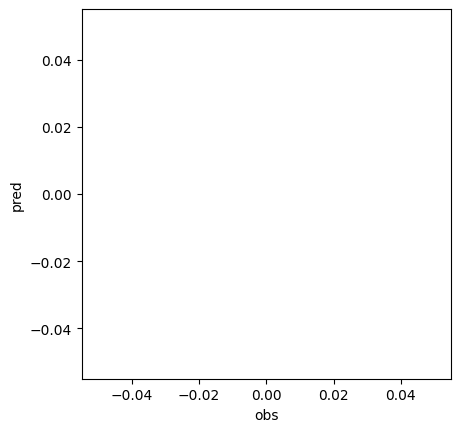

In [78]:
fig, ax = plt.subplots(figsize=(6, 6))
basin_results.plot.scatter('obs','pred')
# plt.xlim([-0.005,0.12])
# plt.ylim([-0.005,0.12])
plt.gca().axis('square')
plt.show()